# <b>AASD 4015 - Advance Mathematical Concepts for Deep Learning Group Project 2</b>

<b>Members:</b> 
1. Saksham Prakash (101410709) 
2. Sik Yin Sun (101409665)

## Background and Motivation

## <b> 1. Installing and Importing libraries </b>
<a id='lib'></a>

In [29]:
# import os
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16, inception_v3, efficientnet_v2
# from tensorflow.keras.layers import Flatten,Dense
# from tensorflow.keras.models import Model
# from vit_keras import vit

# from tensorflow.keras import layers
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.optimizers import Adam

# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import numpy as np

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, inception_v3, efficientnet_v2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from vit_keras import vit

In [32]:
def plot_accuracy_and_loss(history):
    fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

    ax[0].plot(history.history['accuracy'], label="Train accuracy")
    ax[0].plot(history.history['val_accuracy'], label="Validation accuracy")
    ax[0].set_title("Model accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("accuracy")
    ax[0].legend(["train", "val"])
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(history.history['loss'], label="Train loss")
    ax[1].plot(history.history['val_loss'], label="Validation loss")
    ax[1].set_title("Model loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("loss")
    ax[1].legend(["train", "val"])
    ax[1].grid(True)
    ax[1].legend()

    plt.show()

def display_confusion_matrix(y_true, y_pred):
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def print_classification_report(y_true, y_pred, class_names):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

def evaluate_model(model, train_data, val_data, test_data, epochs=10, batch_size=16):
    
    # Train the model
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, batch_size=batch_size)
    
    # Model summary
    print("\nModel Summary:")
    model.summary()

    # Plot training and loss plots
    plot_accuracy_and_loss(history)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"\nTest accuracy: {test_accuracy}")
    
    # Confusion Matrix and Classification Report
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred = np.squeeze(np.round(model.predict(test_data)))
    
    display_confusion_matrix(y_true, y_pred)
    print_classification_report(y_true, y_pred, train_data.class_names)

In [3]:
!pip install tensorflow-addons
!pip install vit-keras
!pip install typing_extensions
!pip install typeguard

In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## <b>2. Data - Chest X-Ray Images (Pneumonia)</b>
<font size=3>The link of Data:</font>
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [15]:
train_dir = "./chest_xray/train"
val_dir = "./chest_xray/val"
test_dir = "./chest_xray/test"

In [16]:
img_height = 320
img_width = 320
batch_size = 16

In [17]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2023-04-06 02:42:51.311307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
class_label = train_data.class_names
class_label

['NORMAL', 'PNEUMONIA']

In [19]:
train_num = []
val_num = []
test_num = []
print("Train Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(train_dir, i)))
    train_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nValidation Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(val_dir, i)))
    val_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nTest Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(test_dir, i)))
    test_num.append(num_files)
    print(f"{i}: {num_files} files")

Train Data
NORMAL: 1341 files
PNEUMONIA: 3875 files

Validation Data
NORMAL: 8 files
PNEUMONIA: 8 files

Test Data
NORMAL: 234 files
PNEUMONIA: 390 files


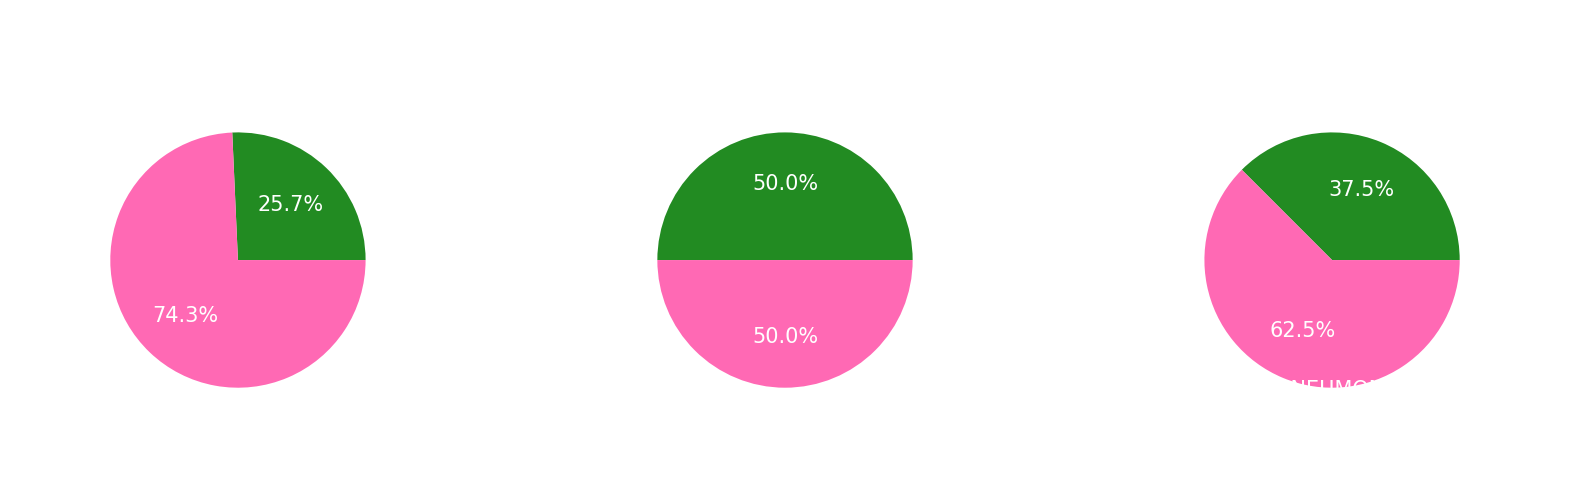

In [20]:
colors = ['#228b22', '#ff69b4']
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
axs[0].pie(train_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[0].set_title('Distribution of Images Across Classes for Train Data', color="white")
axs[1].pie(val_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[1].set_title('Distribution of Images Across Classes for Validation Data', color="white")
axs[2].pie(test_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[2].set_title('Distribution of Images Across Classes for Test Data', color="white")
plt.show()

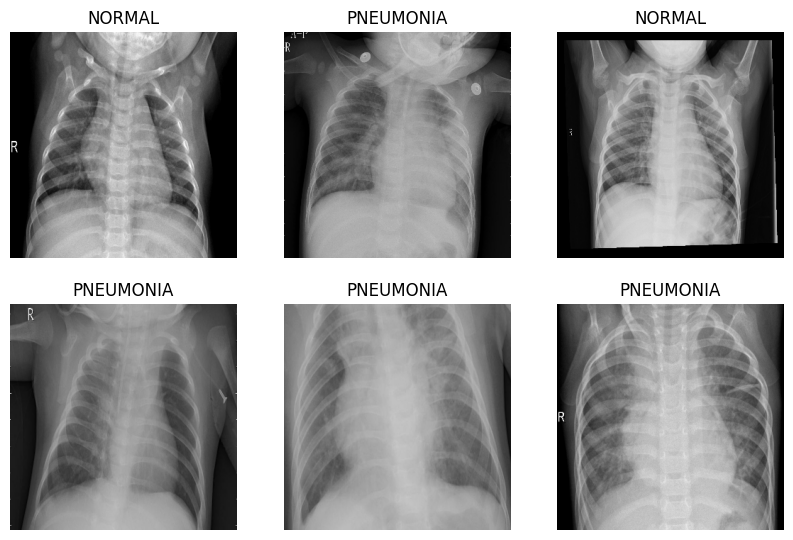

In [21]:
plt.figure(figsize = (10,10))
for images, labels in train_data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_label[labels[i]])
    plt.axis('off')

<font size=3>After briefly exploring the data, we found out that there is a vast difference between "normal" and "pneumonia" for the train data. Additionally, we found that there is more pneumonia record than normal. From the image above, we can see them for people with pneumonia. Their X-ray pictures are much blurry than normal people, and we believe that is because the lung infection causes some fluid there.</font>

## <b> 3.1 VGG </b>

In [12]:
image_size = (img_height, img_width,3) 

In [13]:
vgg16 = VGG16(include_top = False, weights = 'imagenet',input_shape = image_size)

# freeze the vgg16 and create our own head
for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)
x = Dense(1, activation="sigmoid")(x)

vgg16 = Model(inputs=vgg16.input, outputs=x)
vgg16.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

In [14]:
history = vgg16.fit(train_data, epochs=20,validation_data = val_data)

Epoch 1/20
 30/326 [=>............................] - ETA: 11:32 - loss: 6.8430 - accuracy: 0.8396

KeyboardInterrupt: 

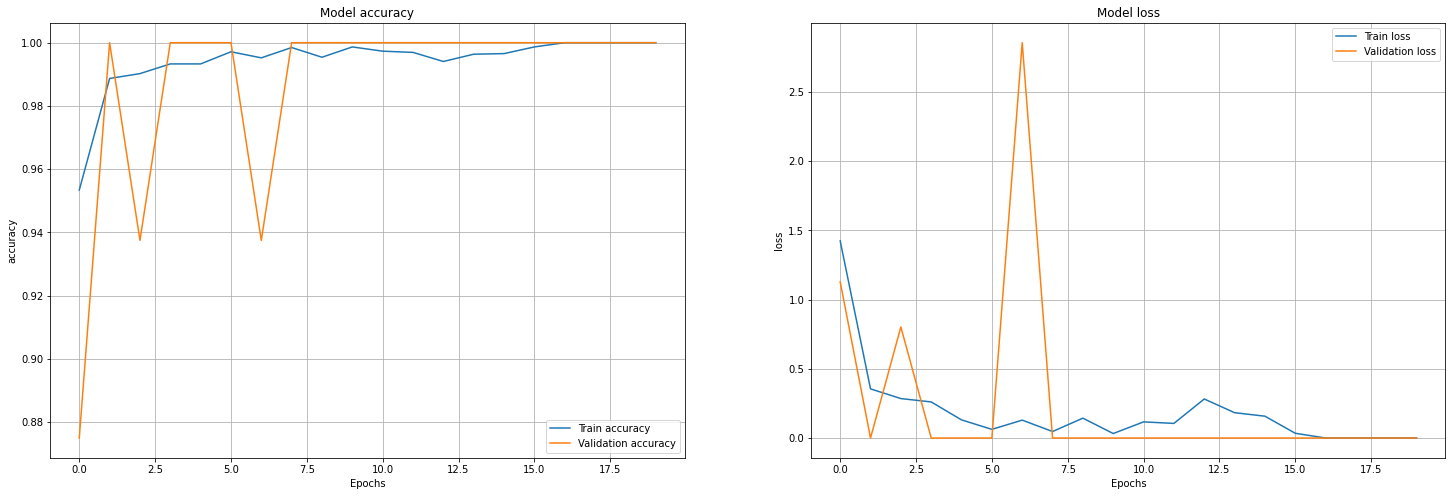

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

ax[0].plot(history.history['accuracy'], label="Train accuracy")
ax[0].plot(history.history['val_accuracy'], label="Validation accuracy")
ax[0].set_title("Model accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend(["train", "val"])
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history.history['loss'], label="Train loss")
ax[1].plot(history.history['val_loss'], label="Validation loss")
ax[1].set_title("Model loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].legend(["train", "val"])
ax[1].grid(True)
ax[1].legend()

plt.show()

### Maybe adding confusion Matrix and Classification???

## <b> 3.2 InceptionV3 </b>

In [28]:
iv3 = inception_v3.InceptionV3(include_top = False, weights = 'imagenet',input_shape = image_size)

# freeze the vgg16 and create our own head
for layer in iv3.layers:
    layer.trainable = False
    
x = Flatten()(iv3.output)
x = Dense(1, activation="sigmoid")(x)

iv3 = Model(inputs=iv3.input, outputs=x)
iv3.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

87910968/87910968 [==============================] - 2s 0us/step


In [30]:
history_iv3 = iv3.fit(train_data, epochs=20,validation_data = val_data)

Epoch 1/20
326/326 [==============================] - 27s 82ms/step - loss: 8.1393 - accuracy: 0.9576 - val_loss: 18.4954 - val_accuracy: 0.8750
Epoch 2/20
326/326 [==============================] - 24s 74ms/step - loss: 9.1972 - accuracy: 0.9582 - val_loss: 130.0177 - val_accuracy: 0.5625
Epoch 3/20
326/326 [==============================] - 24s 73ms/step - loss: 6.1502 - accuracy: 0.9693 - val_loss: 198.9117 - val_accuracy: 0.5625
Epoch 4/20
326/326 [==============================] - 24s 74ms/step - loss: 7.1674 - accuracy: 0.9697 - val_loss: 216.6636 - val_accuracy: 0.6250
Epoch 5/20
326/326 [==============================] - 24s 73ms/step - loss: 5.6174 - accuracy: 0.9747 - val_loss: 206.3827 - val_accuracy: 0.5625
Epoch 6/20
326/326 [==============================] - 24s 73ms/step - loss: 7.0157 - accuracy: 0.9720 - val_loss: 375.3767 - val_accuracy: 0.6250
Epoch 7/20
326/326 [==============================] - 24s 74ms/step - loss: 4.5122 - accuracy: 0.9810 - val_loss: 106.7922 - 

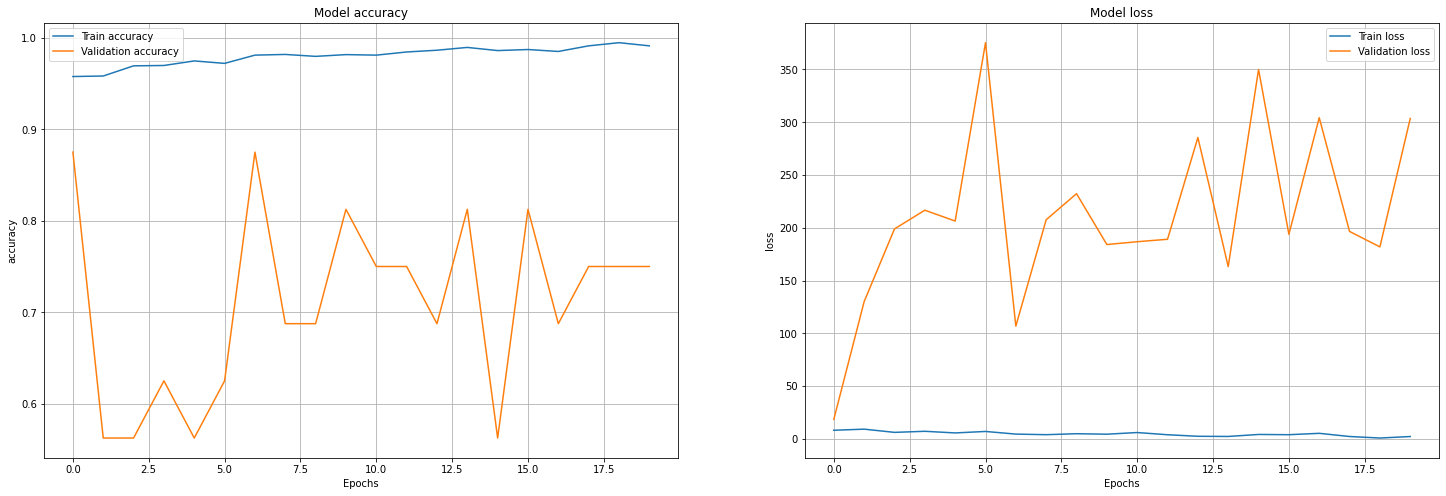

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

ax[0].plot(history_iv3.history['accuracy'], label="Train accuracy")
ax[0].plot(history_iv3.history['val_accuracy'], label="Validation accuracy")
ax[0].set_title("Model accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend(["train", "val"])
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history_iv3.history['loss'], label="Train loss")
ax[1].plot(history_iv3.history['val_loss'], label="Validation loss")
ax[1].set_title("Model loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].legend(["train", "val"])
ax[1].grid(True)
ax[1].legend()

plt.show()

## <b> 3.3 EffientNetV2B3 </b>

In [33]:
eff_v2 = efficientnet_v2.EfficientNetV2B3(include_top = False, weights = 'imagenet',input_shape = image_size)

# freeze the vgg16 and create our own head
for layer in eff_v2.layers:
    layer.trainable = False
    
x = Flatten()(eff_v2.output)
x = Dense(1, activation="sigmoid")(x)

eff_v2 = Model(inputs=eff_v2.input, outputs=x)
eff_v2.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])# binary cross entropy loss function is used for binary classification

52606240/52606240 [==============================] - 1s 0us/step


In [34]:
history_eff_v2 = eff_v2.fit(train_data, epochs=20,validation_data = val_data)

Epoch 1/20
326/326 [==============================] - 45s 105ms/step - loss: 0.6784 - accuracy: 0.9519 - val_loss: 0.6911 - val_accuracy: 0.9375
Epoch 2/20
326/326 [==============================] - 31s 96ms/step - loss: 0.3376 - accuracy: 0.9755 - val_loss: 2.5561e-11 - val_accuracy: 1.0000
Epoch 3/20
326/326 [==============================] - 32s 96ms/step - loss: 0.2181 - accuracy: 0.9854 - val_loss: 8.6792e-20 - val_accuracy: 1.0000
Epoch 4/20
326/326 [==============================] - 31s 96ms/step - loss: 0.2082 - accuracy: 0.9856 - val_loss: 5.5913e-05 - val_accuracy: 1.0000
Epoch 5/20
326/326 [==============================] - 31s 96ms/step - loss: 0.2595 - accuracy: 0.9845 - val_loss: 3.2605e-31 - val_accuracy: 1.0000
Epoch 6/20
326/326 [==============================] - 31s 96ms/step - loss: 0.1379 - accuracy: 0.9921 - val_loss: 0.7562 - val_accuracy: 0.9375
Epoch 7/20
326/326 [==============================] - 31s 95ms/step - loss: 0.1491 - accuracy: 0.9921 - val_loss: 1.088

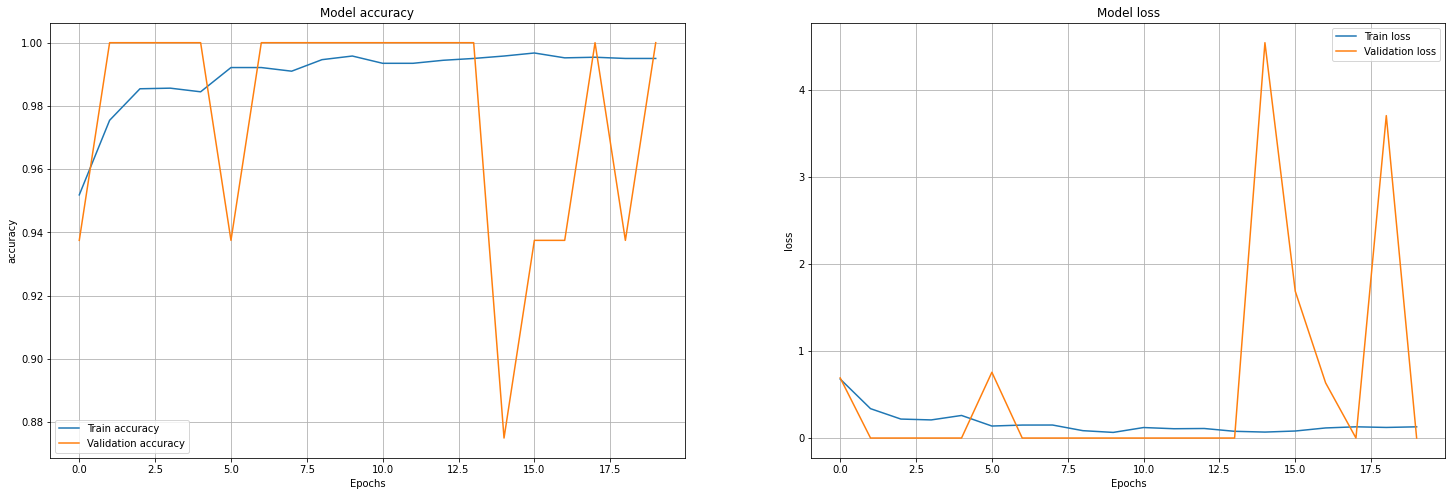

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

ax[0].plot(history_eff_v2.history['accuracy'], label="Train accuracy")
ax[0].plot(history_eff_v2.history['val_accuracy'], label="Validation accuracy")
ax[0].set_title("Model accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend(["train", "val"])
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history_eff_v2.history['loss'], label="Train loss")
ax[1].plot(history_eff_v2.history['val_loss'], label="Validation loss")
ax[1].set_title("Model loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].legend(["train", "val"])
ax[1].grid(True)
ax[1].legend()

plt.show()

## <b> 4.0 Attention </b>

In [21]:
# Load VGG-16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the VGG-16 layers to use them as feature extractors
for layer in base_model.layers:
    layer.trainable = False

The `SelfAttention` class is a custom implementation of a self-attention mechanism, which is a simplified version of the multi-head attention mechanism. The self-attention mechanism allows the model to weigh the importance of different features in the input by attending to different parts of the input. Here's a breakdown of the `SelfAttention` class:

1. `__init__(self, d_k)`: The constructor takes a single argument `d_k`, which is the dimension of the key, query, and value vectors in the attention mechanism. It initializes the class by calling the base class constructor and storing the `d_k` value.

2. `build(self, input_shape)`: This method is called when the layer is added to the model, and it initializes the weight matrices for the key (WK), query (WQ), and value (WV) projections. The weight matrices are of shape `(input_shape[-1], self.d_k)` and are initialized using the Glorot uniform distribution.

3. `call(self, inputs)`: This method is called during the forward pass of the model when the layer processes the input data. It takes the input tensor and does the following:

   a. Computes the query (Q), key (K), and value (V) matrices by multiplying the input tensor with the corresponding weight matrices (WQ, WK, WV).
   
   b. Calculates the attention logits by computing the dot product of the query (Q) and key (K) matrices, and scales the result by the square root of `d_k` to avoid gradients becoming too small or too large.
   
   c. Applies the softmax function to the attention logits to obtain the attention weights, which represent the importance of each feature in the input.
   
   d. Computes the attention output by multiplying the attention weights with the value (V) matrix. This output is a weighted sum of the input features according to their attention weights.
   
The `SelfAttention` layer outputs the attention output, which can be fed to the next layer in the model. In our case, it is followed by the classification layer with a softmax activation function.

In [26]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_k):
        super(SelfAttention, self).__init__()
        self.d_k = d_k

    def build(self, input_shape):
        self.WQ = self.add_weight(name='WQ', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)
        self.WK = self.add_weight(name='WK', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)
        self.WV = self.add_weight(name='WV', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        Q = tf.linalg.matmul(inputs, self.WQ)
        K = tf.linalg.matmul(inputs, self.WK)
        V = tf.linalg.matmul(inputs, self.WV)
        attention_logits = tf.linalg.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.d_k, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        attention_output = tf.linalg.matmul(attention_weights, V)
        return attention_output

In [37]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_k):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_k
        self.attention_heads = [SelfAttention(d_k=self.d_k) for _ in range(self.num_heads)]

    def call(self, inputs):
        attention_outputs = [head(inputs) for head in self.attention_heads]
        multihead_output = tf.concat(attention_outputs, axis=-1)
        return multihead_output

In [27]:
# Add Global Average Pooling 2D layer
global_avg_pool = layers.GlobalAveragePooling2D()(base_model.output)

# Add self-attention layer
attention_output = SelfAttention(d_k=64)(global_avg_pool)

In [29]:
# Add classification layer with two classes (pneumonia and normal)
predictions = layers.Dense(1, activation='sigmoid')(attention_output)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10, batch_size=batch_size)

# Test the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 80, 128)       0   

KeyboardInterrupt: 

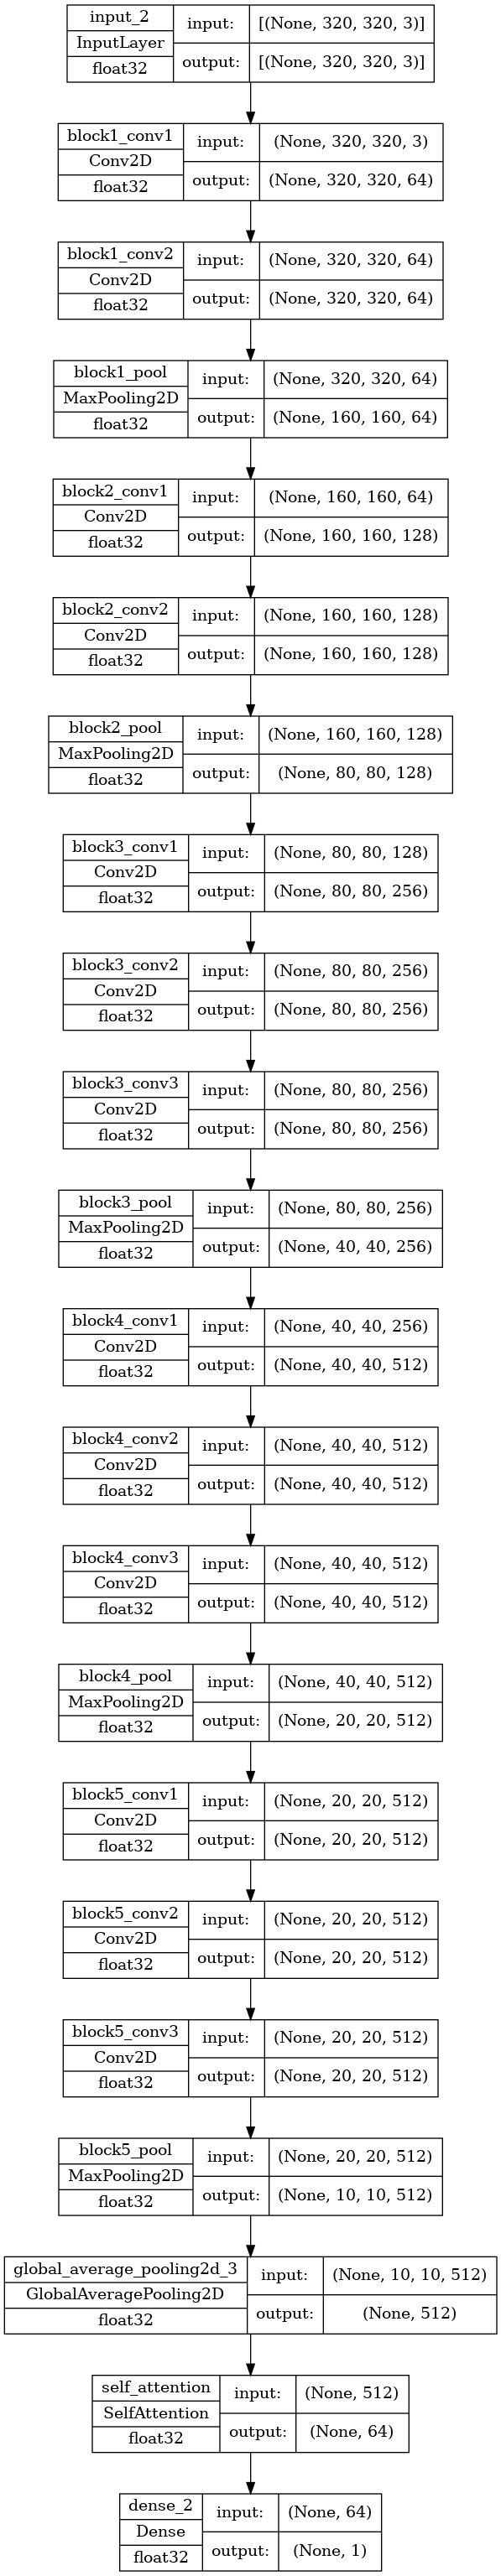

In [31]:

kutils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='model.png')

In [38]:
# Flatten the output of the VGG-16 model
flatten_output = layers.Flatten()(base_model.output)

# Add Global Average Pooling 1D layer
global_avg_pool = layers.GlobalAveragePooling1D()(flatten_output[:, None, :])

# Add custom multi-head attention layer
attention_output = MultiHeadSelfAttention(num_heads=2, d_k=64)(global_avg_pool)

# Add flatten layer
flatten_attention_output = layers.Flatten()(attention_output)

# Add classification layer with sigmoid activation
predictions = layers.Dense(1, activation='sigmoid')(flatten_attention_output)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with binary cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10, batch_size=batch_size)

# Test the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 80, 128)       0   

KeyboardInterrupt: 

In [27]:
# Define the ViT model
def create_vit_classifier():
    model = vit.vit_b32(
        image_size=img_height,
        activation='sigmoid',
        pretrained=True,
        include_top=True,
        pretrained_top=False,
        classes=1,
        weights='imagenet21k'
    )

    input_layer = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)  # Normalize the input images
    output = model(x)

    return tf.keras.Model(inputs=input_layer, outputs=output)

# Create and compile the model
vit_classifier = create_vit_classifier()
vit_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

# Train the model
history = vit_classifier.fit(train_data, epochs=10, validation_data=val_data)

# Evaluate the model on the test set
test_loss, test_accuracy = vit_classifier.evaluate(test_data)
print(f"Test accuracy: {test_accuracy}")

/home/saksham/anaconda3/envs/aasd4011/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 7, 7 to 10, 10
  warnings.warn(


Epoch 1/10
 24/326 [=>............................] - ETA: 11:16 - loss: 0.7850 - accuracy: 0.6432

KeyboardInterrupt: 

In [34]:
evaluate_model(vit_classifier, train_data, val_data, test_data, epochs=10, batch_size=16)

Epoch 1/10
  1/326 [..............................] - ETA: 13:20 - loss: 0.5269 - accuracy: 0.8125

KeyboardInterrupt: 